In [2]:
import numpy as np
import math
import torch
from torch import nn

import scipy.stats as stats
import matplotlib
import matplotlib.pyplot as plt
from livelossplot import PlotLosses
from Inference.GeNVI_method import GeNVariationalInference, GeNetEns

In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

# Target density #

In [4]:
def _logtarget(theta, device=device):
    """
    Evaluation of log proba with density N(0,I_n)

    Parameters:
    x (Tensor): Data tensor of size NxD

    Returns:
    logproba (Tensor): size N, vector of log probabilities
    """
    
    
    
    dim = theta.shape[1]
    S = torch.Tensor([.5,.1]).to(device)
    mu = torch.Tensor([0., 0.]).to(device)
    n_x = theta.shape[0]
    
    MM=torch.Tensor([[1.,0.],
                [1., -1.]])
    theta=torch.matmul(MM.view(1,2,2),torch.pow(theta, torch.Tensor([3.,1.])).view(n_x,2,1)).squeeze(0)
    #theta=torch.pow(theta, torch.Tensor([1.,.3]))
    #print(theta.shape)

    H = S.view(dim, 1, 1).inverse().view(1, 1, dim)
    d = ((theta.view(n_x,dim)-mu.view(1, dim))**2).view(n_x, dim)
    #const = 0.5*S.log().sum()+0.5*dim*torch.tensor(2*math.pi).log()
    v=torch.pow(H*d, torch.Tensor([4., 1.]))
    return -0.5*(v).sum(2).squeeze()


theta=np.pi/3.
def M(theta):
    M=torch.Tensor([[np.cos(theta),-np.sin(theta)],
                [np.sin(theta), np.cos(theta)]])
    return M


def logtarget(theta, device=device):
    """
    Evaluation of log proba with density N(0,I_n)

    Parameters:
    x (Tensor): Data tensor of size NxD

    Returns:
    logproba (Tensor): size N, vector of log probabilities
    """
    
    
    
    dim = theta.shape[1]
    S = torch.Tensor([.5,.05]).to(device)
    mu = torch.Tensor([0., 0.]).to(device)
    n_x = theta.shape[0]
    
    MM=torch.Tensor([[.5,0.],
                [.5, -1.]])
    theta=torch.matmul(MM.view(1,2,2),torch.pow(theta, torch.Tensor([2.,1.])).view(n_x,2,1)).squeeze(0)
    #theta=torch.pow(theta, torch.Tensor([1.,.3]))
    #print(theta.shape)

    H = S.view(dim, 1, 1).inverse().view(1, 1, dim)
    d = ((theta.view(n_x,dim)-mu.view(1, dim))**2).view(n_x, dim)
    #const = 0.5*S.log().sum()+0.5*dim*torch.tensor(2*math.pi).log()
    v=torch.pow(H*d, torch.Tensor([4., 1.]))
    return -0.5*(v).sum(2).squeeze()

def logtarget_(x):
    n=x.shape[0]
    return -(-d.log_prob(torch.matmul(M(theta).view(1,2,2),x.view(n,2,1)).squeeze(0-1))).pow(4.)

def logtarget__(x):
    n=x.shape[0]
    a=-(-d.log_prob(torch.matmul(M(theta).view(1,2,2),x.view(n,2,1)).squeeze(0-1))).pow(4.)
    b=-(-dd.log_prob(torch.matmul(M(-theta).view(1,2,2),x.view(n,2,1)).squeeze(0-1))).pow(2.)
    return a+b- torch.tensor(2.).log()

In [5]:
%matplotlib notebook


x=y=torch.arange(-2.,2.,0.02)
grid_x, grid_y = torch.meshgrid(x, y)
p=torch.Tensor(grid_x.shape)

for i in range(p.shape[0]):
    for j in range(p.shape[1]):
        x=torch.Tensor([grid_x[i,j],grid_y[i,j]]).unsqueeze(0)
        p[i,j]=logtarget(x).squeeze()



<IPython.core.display.Javascript object>


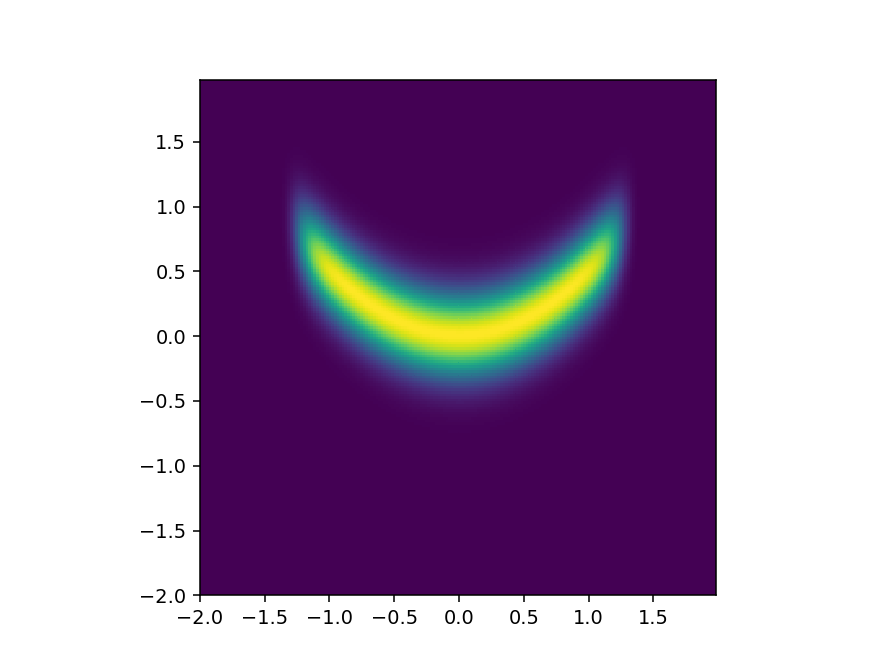

(-2.0, 1.9800000190734863, -2.0, 1.9800000190734863)

In [6]:
%matplotlib notebook
plt.pcolormesh(grid_x.numpy(),grid_y.numpy(),p.exp().numpy())
plt.axis('scaled')


# AE-Variational Distribution #

In [19]:
activation = nn.ReLU()
init_b = .001

GeN = GeNetEns(1, 1, 50, 2, activation, 0.1, init_b, device)

<IPython.core.display.Javascript object>


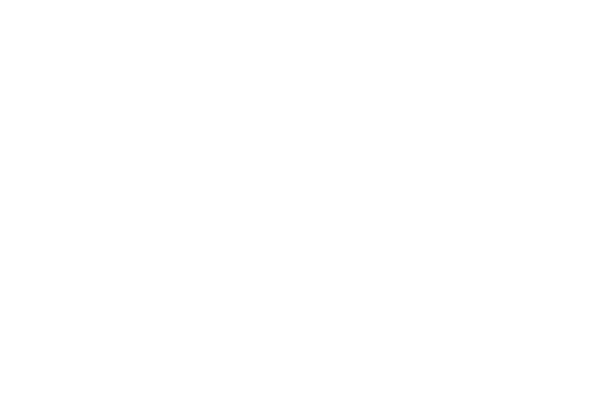

<IPython.core.display.Javascript object>


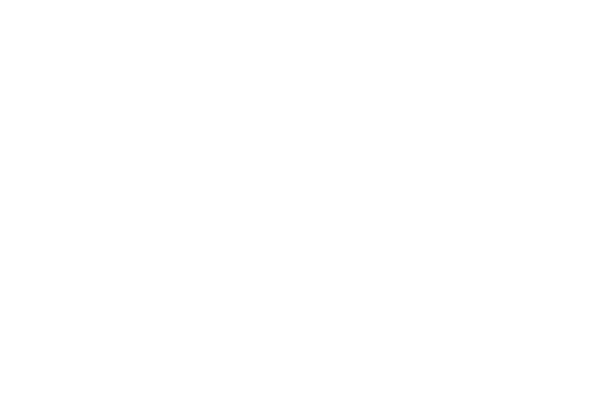

In [20]:
%matplotlib notebook


Z=GeN(1000).detach()

plt.pcolormesh(grid_x.numpy(),grid_y.numpy(),p.exp().numpy())
plt.scatter(Z[:,0],Z[:,1],color='red') 


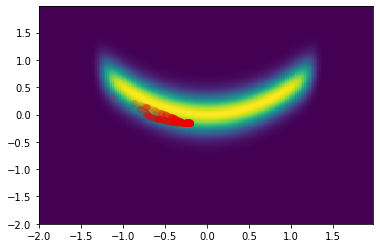

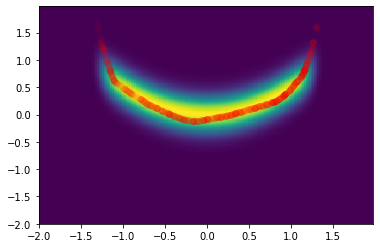

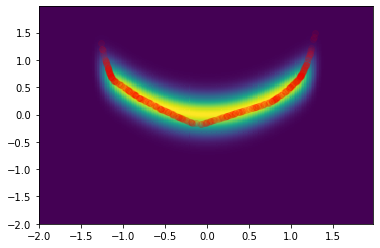

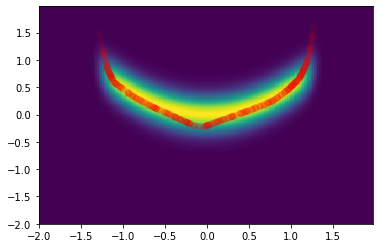

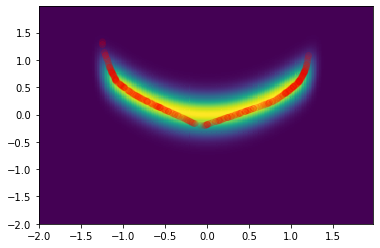

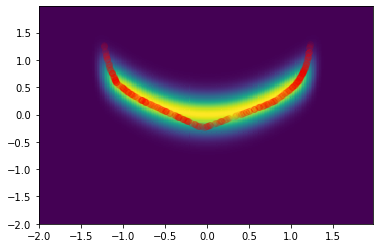

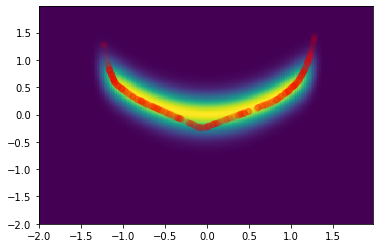

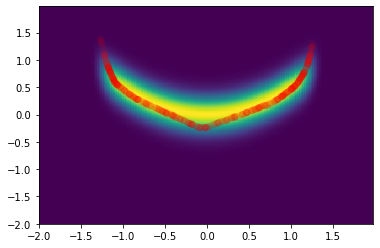

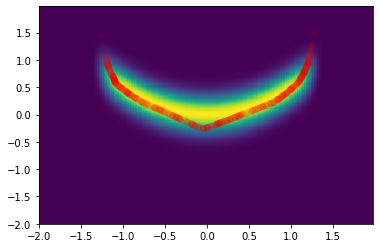

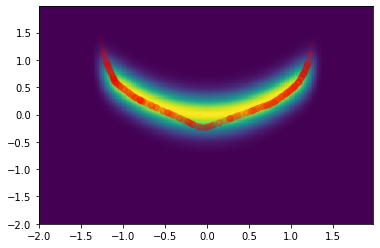

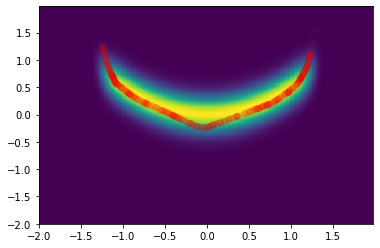

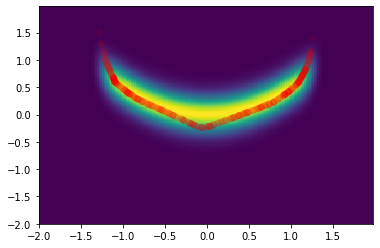

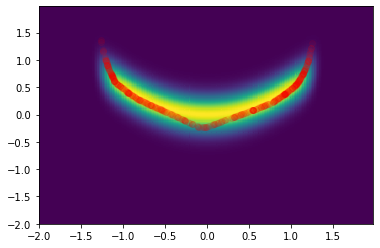

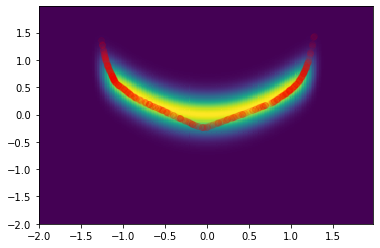

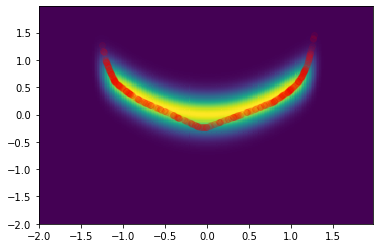

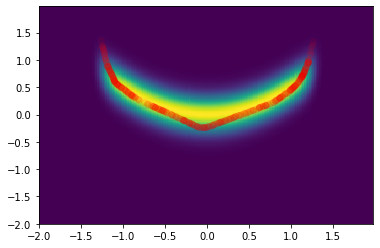

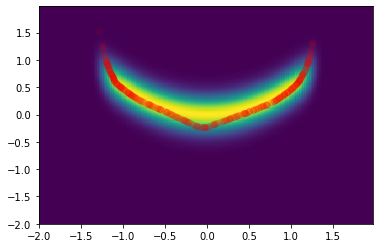

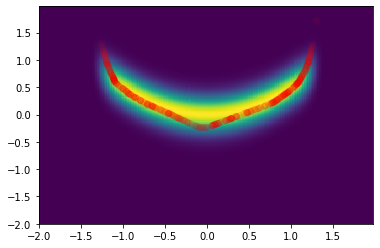

755


In [21]:
%matplotlib inline
from tempfile import TemporaryDirectory





#sample, = ax.scatter([],[],color='red',alpha=0.07)
#fig.canvas.draw()
    
    

def show(GeN,n):
    Z=GeN(n).detach().clone().cpu()
    plt.pcolormesh(grid_x.numpy(),grid_y.numpy(),p.exp().numpy())
    plt.scatter(Z[:,0],Z[:,1],color='red',alpha=0.07) 
    plt.draw()
    plt.show()
    
    

with TemporaryDirectory() as temp_dir:
    optimizer = GeNVariationalInference(logtarget,
		                                    0, 100, 1000, 50, 100,
		                                    10000, .01, .000001, 100, .5,
		                                    device, False, temp_dir, save_best=True)
    best_epoch, scores=optimizer.run(GeN,show)
print(best_epoch)

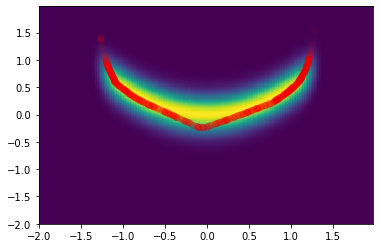

In [22]:
%matplotlib inline

show(GeN,1000)



In [23]:
from Inference.GeNVI_method import KDE


%matplotlib notebook

x=y=torch.arange(-2.,2.,0.02)
grid_x, grid_y = torch.meshgrid(x, y)
q=torch.Tensor(grid_x.shape)

Z=GeN.sample(1000).detach()

for i in range(q.shape[0]):
    for j in range(q.shape[1]):
        #x=torch.Tensor([grid_x[i,j],grid_y[i,j]]).unsqueeze(0)
        q[i,j]=KDE(torch.cat([grid_x[i,j].unsqueeze(0),grid_y[i,j].unsqueeze(0)]).unsqueeze(0),Z,device).squeeze(-1)


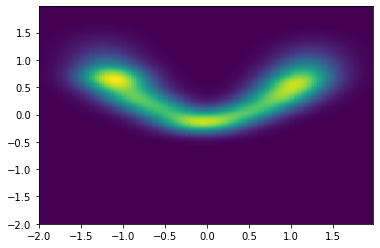

In [25]:
%matplotlib inline

plt.pcolormesh(grid_x.numpy(),grid_y.numpy(),q.exp().numpy())
plt.show()

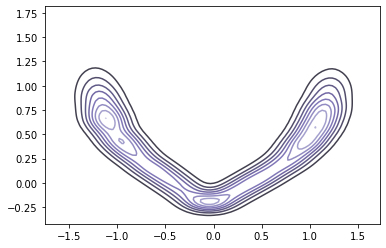

In [24]:
%matplotlib inline 
import seaborn as sns

sample=GeN(10000).detach().numpy()

sns.kdeplot(sample[:,0],sample[:,1], cmap="Purples_d")
